# Тестовое задание
Написать и обучить модель-автокодировщик на датасете на выбор: CIFAR10, CIFAR100.
Обучить модель-классификатор на латентных представлениях обученного автокодировщика.


### Рекомендуемые шаги для выполнения задания

**Шаг 1.** Подготовка инфраструктуры.

Создание окружения, организация структуры репозитория, загрузка датасетов.

**Шаг 2.** Реализовать модель-автоенкодер.

Выбрать архитектуру и реализовать ее совместно с процедурой обучения, подходящей для выбранного датасета.
Важно обратить внимание на выбор размерность скрытого состояния. Обосновать свой выбор.

**Шаг 3.** Обучить автоенкодер.

Нужно обучить реализованную архитектуру на скаченном датасете.
Оценить качество работы модели.

**Шаг 4.** Реализовать модель-классификатор.

Реализовать небольшую модель классификатор на скрытых представлениях уже обученного автоенкодера.
Реализовать пайплайн обучения данной модели.

**Шаг 5.** Обучение модели классификатора и визуализация результатов.

На этом шаге требуется обучить модель классификатор и оценить ее качество.
Подумайте, в каком виде было бы удобно провести демонстрацию результатов?

**Шаг 6.** Выводы и идеи.

Проведите анализ результатов, сделайте несколько выводов на основе полученных рузультатов.
Предложите свои идеи, как можно улучшить текущие результаты.


---
## 0. Загрузка библиотек и датасета

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.filterwarnings("ignore")

seed = 128
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Проверка CUDA
torch.cuda.is_available()

True

In [2]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
valid_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_dataset, valid_dataset

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor())

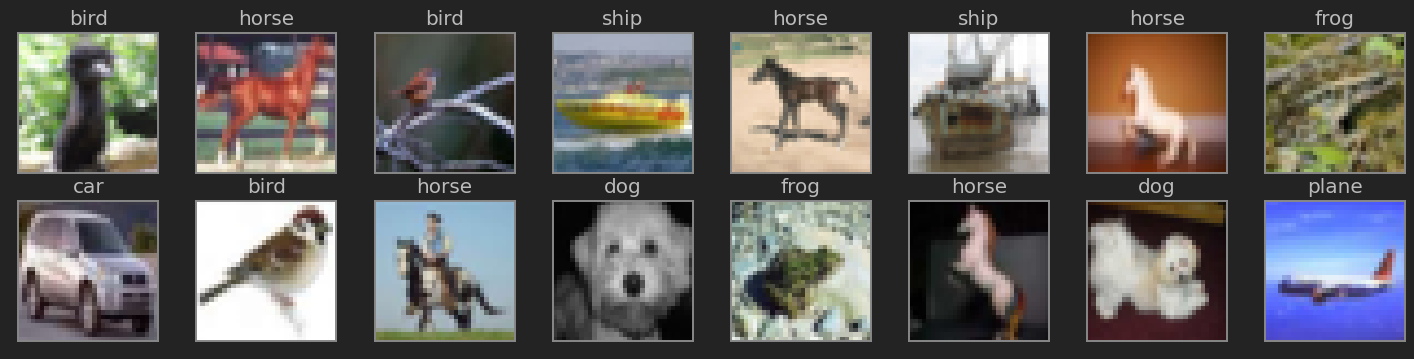

In [3]:
# Посмотрим, что внутри, добавим описание меток из оф. описания
labels_dict = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

figure = plt.figure(figsize=(18, 4))
cols, rows = 8, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_dict[label])
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.transpose(img, axes=(1, 2, 0)))
plt.show()

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=256+128,
                                           shuffle=True,
                                          )
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                          batch_size=256+128,
                                          shuffle=False, 
                                         )

---
## 1. Реализация структуры сети автоэнкодера

In [5]:
# Создадим класс энкодера, декодера (для обучения автоэнкодера) и, собственно, класс полной сети
# Т.к. картинки маленькие, классов мало и они достаточно разные, то использовать что-то большое и тяжелое не целесообразно.
# Соберем свою небольшую сеточку энкодера и зеркального декодера с нормировкой батча для ускорения и небольшой регуляризации

class Encoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()
        self.conv_1st = nn.Conv2d(3, 32, 3)
        self.conv_2nd = nn.Conv2d(32, 64, 3)
        self.conv_3rd = nn.Conv2d(64, 64, 3)
        self.conv_4th = nn.Conv2d(64, 64, 3)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(64*24*24, 128)
        self.hidden = nn.Linear(128, hidden_dim)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.batch_norm_2 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.conv_1st(x)
        x = self.batch_norm_1(x)
        x = F.relu(x)

        x = self.conv_2nd(x)
        x = self.batch_norm_2(x)
        x = F.relu(x)
        x = self.conv_3rd(x)
        x = self.batch_norm_2(x)
        x = F.relu(x)
        x = self.conv_4th(x)
        x = self.batch_norm_2(x)
        x = F.relu(x)
        
        x = self.flat(x)
        x = self.fc(x)
        x = F.relu(x)
        x = self.hidden(x)
        
        return x

class Decoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Decoder, self).__init__()
        self.convt_1st = nn.ConvTranspose2d(64, 64, 3)
        self.convt_2nd = nn.ConvTranspose2d(64, 64, 3)
        self.convt_3rd = nn.ConvTranspose2d(64, 32, 3)
        self.convt_4th = nn.ConvTranspose2d(32, 3, 3)
        self.fc = nn.Linear(128, 64*24*24)
        self.hidden = nn.Linear(hidden_dim, 128)
        self.unflat = nn.Unflatten(dim=1, unflattened_size=(64, 24, 24))
        self.batch_norm_1 = nn.BatchNorm2d(64)
        self.batch_norm_2 = nn.BatchNorm2d(32)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.fc(x)
        x = F.relu(x)
        x = self.unflat(x)
        
        x = self.convt_1st(x)
        x = self.batch_norm_1(x)
        x = F.relu(x)
        x = self.convt_2nd(x)
        x = self.batch_norm_1(x)
        x = F.relu(x)

        x = self.convt_3rd(x)
        x = self.batch_norm_2(x)
        x = F.relu(x)
        x = self.convt_4th(x)
        x = F.relu(x)
        
        return x

class AutoEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super(AutoEncoder, self).__init__()
        self.enc = Encoder(hidden_dim)
        self.dec = Decoder(hidden_dim)
        
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        
        return x

In [6]:
# Запомним device для дальнейшего использования
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
model = AutoEncoder(hidden_dim=4).to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
            Conv2d-3           [-1, 64, 28, 28]          18,496
       BatchNorm2d-4           [-1, 64, 28, 28]             128
            Conv2d-5           [-1, 64, 26, 26]          36,928
       BatchNorm2d-6           [-1, 64, 26, 26]             128
            Conv2d-7           [-1, 64, 24, 24]          36,928
       BatchNorm2d-8           [-1, 64, 24, 24]             128
           Flatten-9                [-1, 36864]               0
           Linear-10                  [-1, 128]       4,718,720
           Linear-11                    [-1, 4]             516
          Encoder-12                    [-1, 4]               0
           Linear-13                  [-1, 128]             640
           Linear-14                [-1

---
## 2. Обучение автоэнкодера

In [8]:
hidden_dimensions = [32, 16, 8]

for dim in hidden_dimensions:
    history = pd.DataFrame(columns=['hidden_dimension', 'epoch', 'train_loss', 'valid_loss'])
    model = AutoEncoder(hidden_dim=dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()  

    print(f'Start training with {dim}-sized hidden dimension')
    for epoch in range(201):  
        
        # TRAIN BLOCK
        model.train()
        loss_train = 0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, inputs.to(device))
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

            # не забываем убирать за собой, чтобы минимизировать риски OOM на GPU
            del inputs, labels
            gc.collect()
            torch.cuda.empty_cache()
            
        # EVAL BLOCK
        model.eval()
        loss_valid = 0
        with torch.no_grad():
            for X, y in valid_loader:
                output = model(X.to(device))
                loss = criterion(output, X.to(device))
                loss_valid += loss.item()
                
                del X, y
                gc.collect()
                torch.cuda.empty_cache()
            
        history.loc[len(history)] = [dim, epoch, loss_train, loss_valid]
    
        if (epoch % 10 == 0):
            print(f"Epoch: {epoch}, train_loss: {loss_train / len(train_loader)}, valid_loss: {loss_valid / len(valid_loader)}")
    
    # сохраним текущую модельку
    torch.save(model.to('cpu').state_dict(), f'./Models/model_{dim}-hidden_dim.pt')   
    history.to_csv(f'./History/history_{dim}-hidden_dim.csv')
    print(f'Training with {dim}-sized hidden dimension is finished!')
    print('=' * 80)

model = model.to('cpu')
print(f'Training is finished!')

Start training with 32-sized hidden dimension
Epoch: 0, train_loss: 0.09546464809593354, valid_loss: 0.18401151840333585
Epoch: 10, train_loss: 0.014475098391639367, valid_loss: 0.1651321561248214
Epoch: 20, train_loss: 0.012830106434874406, valid_loss: 0.15008811045576026
Epoch: 30, train_loss: 0.012289383299364388, valid_loss: 0.09172051924246329
Epoch: 40, train_loss: 0.011873305291790544, valid_loss: 0.07860173422981191
Epoch: 50, train_loss: 0.011328692398680985, valid_loss: 0.07394904284565537
Epoch: 60, train_loss: 0.010977341039888277, valid_loss: 0.07181319759951697
Epoch: 70, train_loss: 0.01048704176316507, valid_loss: 0.07019723068784785
Epoch: 80, train_loss: 0.0100412237820507, valid_loss: 0.06970775789684719
Epoch: 90, train_loss: 0.009687130012414382, valid_loss: 0.07060260463643957
Epoch: 100, train_loss: 0.009297775573857869, valid_loss: 0.06999075136802814
Epoch: 110, train_loss: 0.009008066494103151, valid_loss: 0.07133338959128768
Epoch: 120, train_loss: 0.00877883

In [9]:
history = pd.DataFrame()
for path in glob.glob('./History/history_*.csv'):
    history = pd.concat([history, pd.read_csv(path, index_col=0, dtype={'train_loss': 'float64', 'valid_loss': 'float64'})], axis=0)

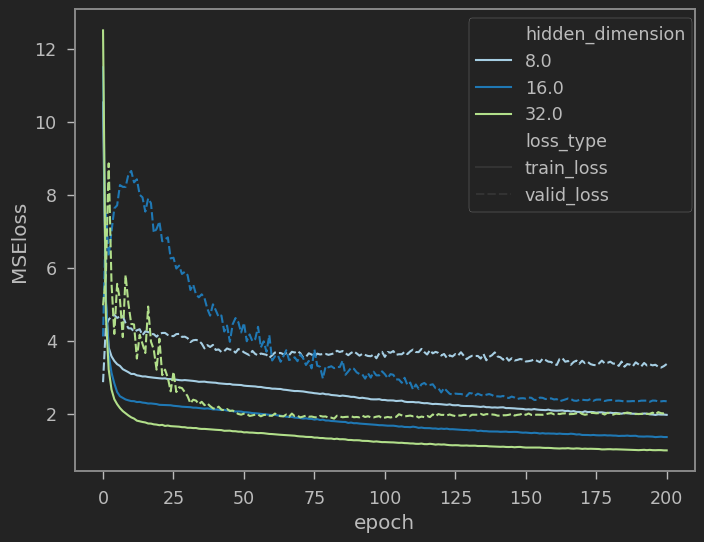

In [10]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=history.melt(id_vars=['hidden_dimension', 'epoch'], 
                               value_vars=['train_loss', 'valid_loss'], 
                               var_name='loss_type',
                               value_name='MSEloss'),
             x='epoch', 
             y='MSEloss',
             hue='hidden_dimension', 
             style='loss_type',
             palette='Paired',
            )
plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.show()

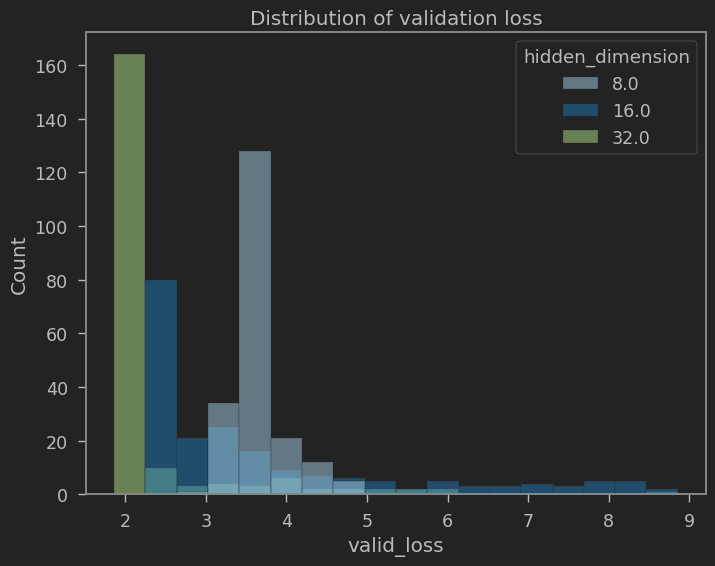

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(data=history, x='valid_loss', hue='hidden_dimension', palette='Paired')
plt.title('Distribution of validation loss')
plt.show()

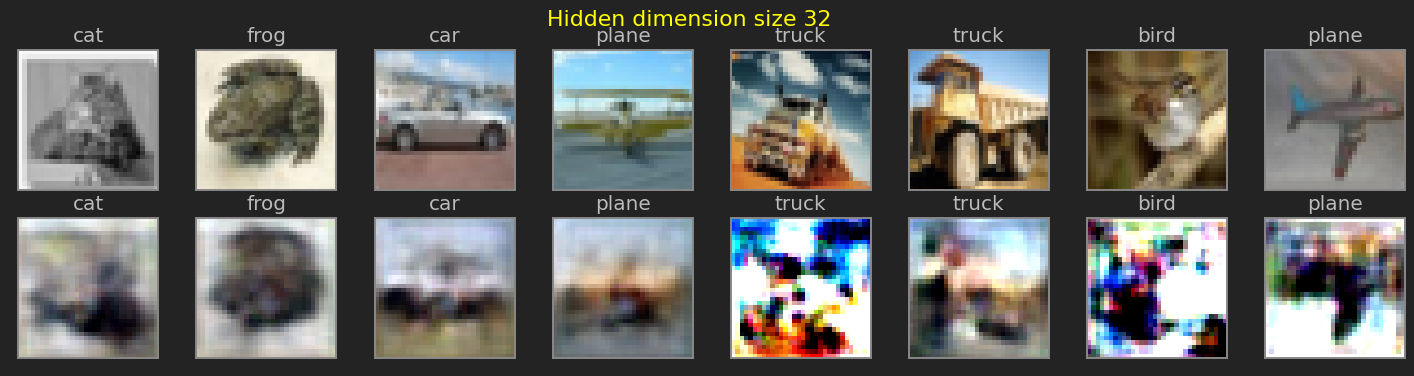

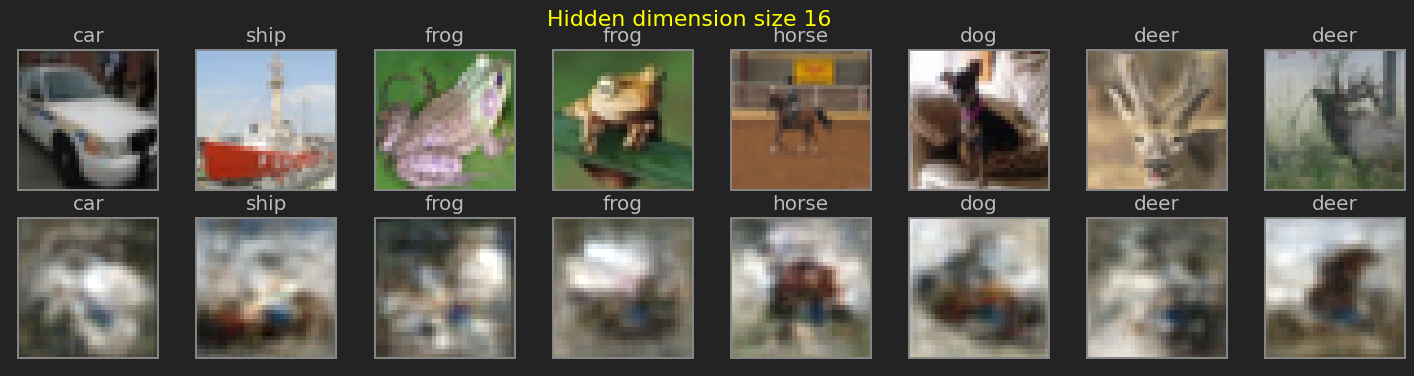

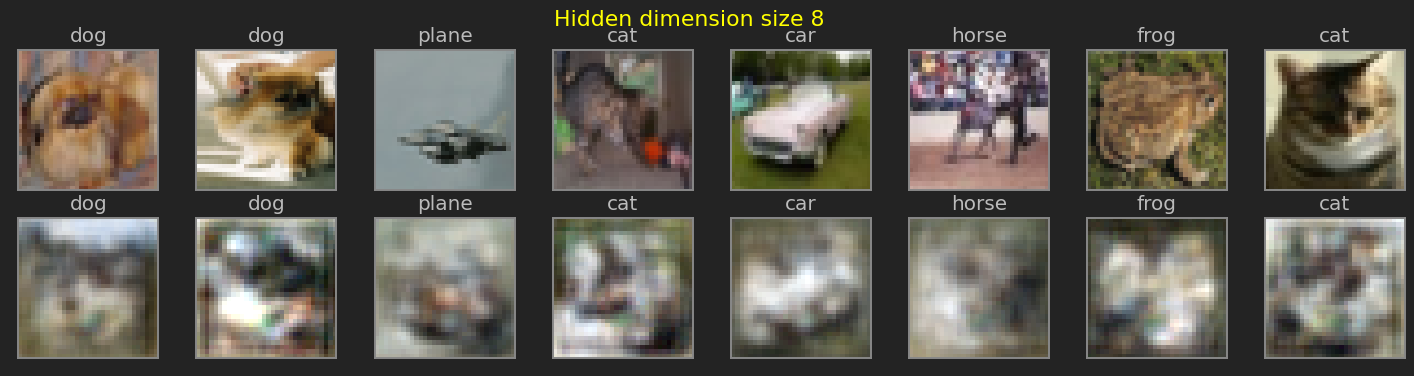

In [36]:
device = torch.device('cpu')
for chosen_dim in [32, 16, 8]:
    model = AutoEncoder(hidden_dim=chosen_dim)
    model.load_state_dict(torch.load(f'./Models/model_{chosen_dim}-hidden_dim.pt', map_location=device))

    figure = plt.figure(figsize=(18, 4))
    cols, rows = 8, 2
    for i in range(1, cols + 1):
        sample_idx = torch.randint(len(valid_dataset), size=(1,)).item()
        img, label = valid_dataset[sample_idx]
        prediction = model(img[None, :, :, :]).detach().numpy()[0]
        prediction[prediction > 1.] = 1.
        
        figure.add_subplot(rows, cols, i)
        plt.title(labels_dict[label])
        plt.xticks([]), plt.yticks([])
        plt.imshow(np.transpose(img, axes=(1, 2, 0)))

        figure.add_subplot(rows, cols, i+8)
        plt.title(labels_dict[label])
        plt.xticks([]), plt.yticks([])
        plt.imshow(np.transpose(prediction, axes=(1, 2, 0)))
    
    plt.suptitle(f'Hidden dimension size {chosen_dim}', color='yellow')
    plt.show()

In [114]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(8, 6))
    for class_idx in range(np.max(targets) + 1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:, 0], X_embedded_class[:, 1])
    plt.legend(labels, bbox_to_anchor=(1.01, 1.0))
    plt.grid(True)

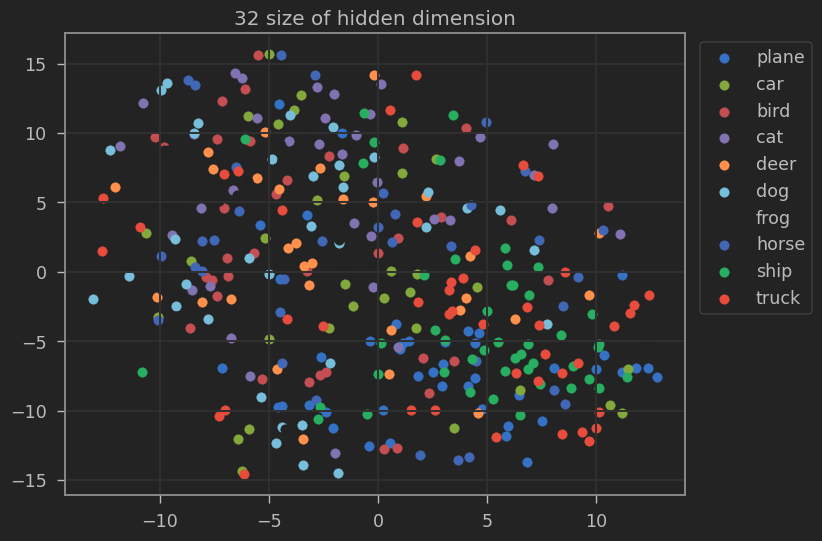

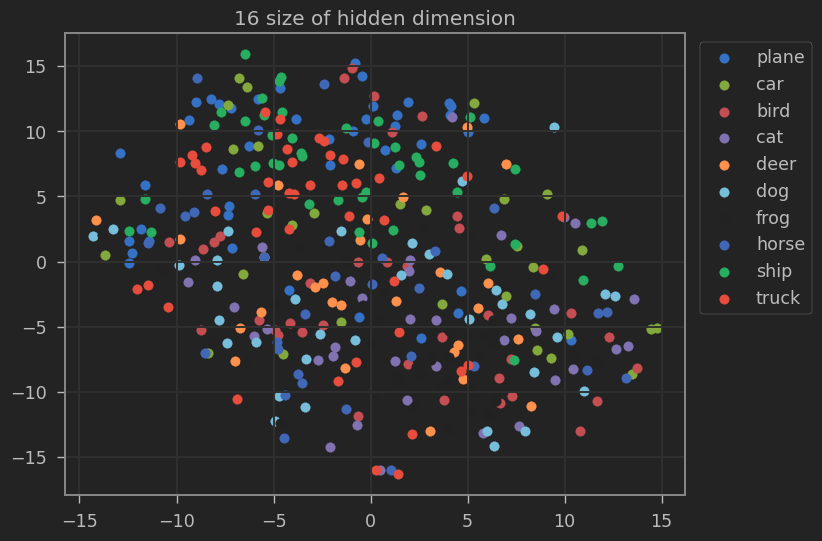

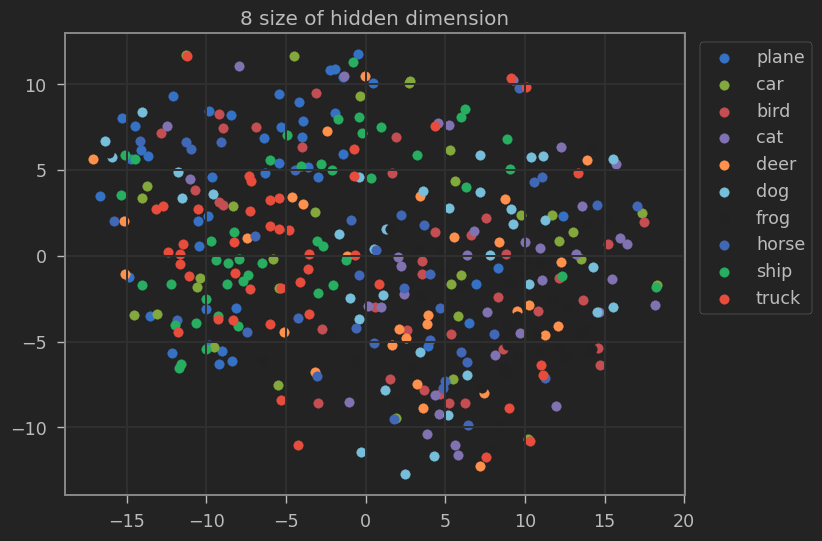

In [115]:
dataloader_iterator = iter(valid_loader)
x, y = next(dataloader_iterator)

for chosen_dim in [32, 16, 8]:
    model = AutoEncoder(hidden_dim=chosen_dim)
    model.load_state_dict(torch.load(f'./Models/model_{chosen_dim}-hidden_dim.pt', map_location=device))
    pretrained_encoder = model.enc
    test_embs = pretrained_encoder(x).detach().numpy()
    test_embs_2D = TSNE(n_components=2).fit_transform(test_embs)
    draw_embeddings(test_embs_2D, y.detach().numpy(), labels_dict.values())
    plt.title(f'{chosen_dim} size of hidden dimension')

### Анализ автоэнкодера
* Автоэкодер сработал плохо. Что-то более менее правдободобное отмечается при значительном увеличении размерности скрытого пространства, что свидетельствует о недостаточной глубине сети. Для улучшения качества автоэнкодера следует добавить 1-2 слоя в энкодере и декодере для извлечения более высокоуровневых фичей, что также позволит уменьшить размерность скрытого пространства. Кроме того, т.к. сеть не сильно глубокая (не глубже 7 слоев), то полезно было бы заменить Relu на Tanh для увеличения нелинейности сети.

* Другой вариант - не заниматься изобретением велосипеда, а взять уже готовую модель, например VGG (её должно хватить для такого уровня задачи) и на её основе сделать автоэкодер (см. второй файл).

---
## 3. Реализация модели-классификатора

Тем не менее, попробуем посмотреть как сработает классификация на текущих энкодерах. Возьмем модельку с 32 hidden dim, т.к. остальные модельки энкодера были слабоваты...

In [191]:
chosen_dim = 32
model = AutoEncoder(hidden_dim=chosen_dim)
model.load_state_dict(torch.load(f'./Models/model_{chosen_dim}-hidden_dim.pt', map_location=device))

# Отрежем энкодер от модели автоэнкодера и зафиксируем его параметры
pretrained_encoder = model.enc
for param in pretrained_encoder.parameters():
    param.requires_grad = False
pretrained_encoder

Encoder(
  (conv_1st): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_2nd): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_3rd): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_4th): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=36864, out_features=128, bias=True)
  (hidden): Linear(in_features=128, out_features=32, bias=True)
  (batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [195]:
class ClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super(ClassificationModel, self).__init__()
        self.enc = pretrained_encoder

        self.fc_1st = nn.Linear(input_dim, 512)
        self.fc_2nd = nn.Linear(512, 1024)
        self.fc_3rd = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.enc(x)

        x = self.fc_1st(x)
        x = F.relu(x)
        
        x = self.fc_2nd(x)
        x = F.relu(x)
        
        x = self.fc_3rd(x)
        x = F.sigmoid(x)
        
        return x

In [196]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [197]:
clas_model = ClassificationModel(input_dim=chosen_dim).to(device)
summary(clas_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
            Conv2d-3           [-1, 64, 28, 28]          18,496
       BatchNorm2d-4           [-1, 64, 28, 28]             128
            Conv2d-5           [-1, 64, 26, 26]          36,928
       BatchNorm2d-6           [-1, 64, 26, 26]             128
            Conv2d-7           [-1, 64, 24, 24]          36,928
       BatchNorm2d-8           [-1, 64, 24, 24]             128
           Flatten-9                [-1, 36864]               0
           Linear-10                  [-1, 128]       4,718,720
           Linear-11                   [-1, 32]           4,128
          Encoder-12                   [-1, 32]               0
           Linear-13                  [-1, 512]          16,896
           Linear-14                 [-

---
## 4.  Обучение модели-классификатора

In [198]:
optimizer = torch.optim.Adam(clas_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [199]:
for epoch in range(31):  
    # TRAIN BLOCK
    clas_model.train()
    loss_train = 0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = clas_model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

        del inputs, labels
        gc.collect()
        torch.cuda.empty_cache()

    # EVAL BLOCK
    clas_model.eval()
    loss_valid = 0.
    accuracy = 0.
    total = 0.
    with torch.no_grad():
        for X, y in valid_loader:
            output = clas_model(X.to(device))
            loss = criterion(output, y.to(device))
            loss_valid += loss.item()
            
            _, predicted = torch.max(clas_model(X.to(device)).data, 1)
            total += y.size(0)
            accuracy += (predicted == y.to(device)).sum().item()

            del X, y
            gc.collect()
            torch.cuda.empty_cache()

    if (epoch % 10 == 0):
        print(f"Epoch: {epoch}, train_loss: {loss_train / len(train_loader)}, valid_loss: {loss_valid / len(valid_loader)}, valid Accuracy: {(100 * accuracy / total)}%")

clas_model = clas_model.to('cpu')
torch.save(clas_model.state_dict(), './Models/classification_model.pt')   
print(f'Training is finished!')

Epoch: 0, train_loss: 2.2287834910036044, valid_loss: 2.2362482106244124, valid Accuracy: 23.19%
Epoch: 10, train_loss: 2.169421458062325, valid_loss: 2.240337045104415, valid Accuracy: 19.47%
Epoch: 20, train_loss: 2.1506435980323615, valid_loss: 2.218380583657159, valid Accuracy: 20.59%
Epoch: 30, train_loss: 2.1248324845583384, valid_loss: 2.2073641971305564, valid Accuracy: 21.7%
Training is finished!


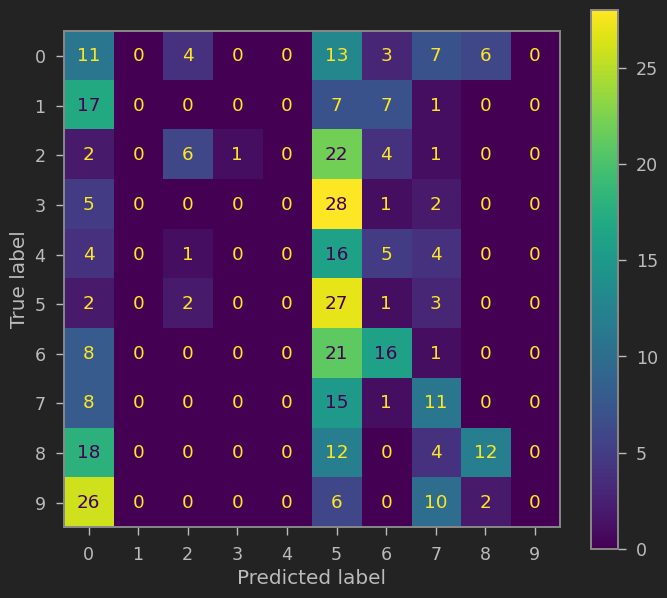

In [204]:
dataloader_iterator = iter(valid_loader)
x, y = next(dataloader_iterator)

_, predicted = torch.max(clas_model(x).data, 1)
cm = confusion_matrix(y, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot( values_format ='.3g')
plt.show()

---
## 5. Выводы и идеи
В видду слабого автоэнкодера модель классификации показала слабые результаты. Для её улучшения требуется "прокачать" автоэнкодер путем увеличения глубины сети, использования в кчестве функции активации tanh (при глубине не выше 7 слоев, дабы не получить исчезающий градиент), а также увеличения числа карт активации внутри слоев. Это таже позволит "запечатать" модель в компактном скрытом пространстве за счет выявления высокоуровневых фичей в процессе обучения. Другой враиант - использовать предобученную сетку и на её основе сделать автоэнкодер, а далее уже повторить шаги по созданию и обучению классификатора (см. второй файл).